In [1]:
import sys, os
sys.path.append(os.pardir)

In [3]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose
import plotly.express as px

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train")

In [4]:
from src.utils.metrics import event_detection_ap
from src.utils.periodicity import get_periodicity_dict
from src.utils.common import trace
from src.utils.post_process import make_submission

periodicity_dict = get_periodicity_dict(cfg)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [87]:
pred_df = (
    pl.read_parquet("./pred_onset.parquet")
    .rename({"label_pred": "stacking_prediction_onset"})
    .drop("label")
    .join(
        pl.read_parquet("./pred_wakeup.parquet")
        .rename({"label_pred": "stacking_prediction_wakeup"})
        .drop("label"),
        on=["series_id", "step"],
        how="left",
    )
)
pred_df = pred_df.with_columns(
    ((pl.col("step") - pl.col("step").shift(1)) != 12)
    .cast(int)
    .cumsum()
    .over("series_id")
    .fill_null(0)
    .alias("chunk_id")
)

In [88]:
pred_df = pred_df.join(event_df, on=['series_id', 'step'], how='left')
pred_df = pred_df.with_columns(
    pl.col('event').is_not_null().cast(pl.UInt64).alias('label')
)
pred_df.head()

series_id,step,stacking_prediction_onset,stacking_prediction_wakeup,chunk_id,night,event,timestamp,label
str,i64,f64,f64,i64,i64,str,"datetime[μs, UTC]",u64
"""038441c925bb""",0,0.000008,0.00001,0,null,null,null,0
"""038441c925bb""",12,0.000008,0.000008,0,null,null,null,0
"""038441c925bb""",24,0.000007,0.000031,0,null,null,null,0
"""038441c925bb""",36,0.000009,0.000019,0,null,null,null,0
"""038441c925bb""",48,0.000006,0.000007,0,null,null,null,0


In [99]:
qcut_num = 200
event2col: dict[str, str] = {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"},

event = "onset"
pred_col = "stacking_prediction_onset"

height=0.001


In [100]:
# キャリブレーション前のプロット

result = pred_df.filter(pl.col(pred_col)>height).with_columns(
    (pl.col(pred_col).qcut(np.linspace(0, 1, qcut_num), allow_duplicates=True, include_breaks=True)).alias(f"{event}_cut")
).unnest(f"{event}_cut").group_by(f"{pred_col}_bin").agg(pl.col('label').mean() , pl.col('brk').mean())

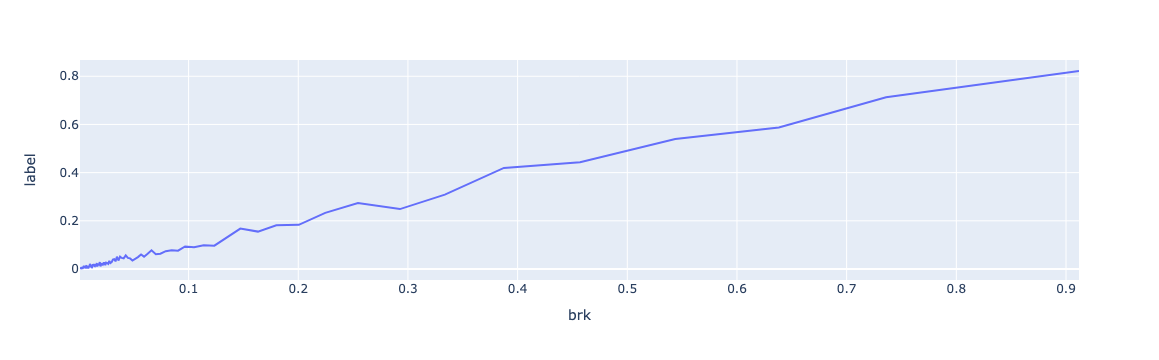

In [101]:
df = result.sort(['brk']).to_pandas()
fig = px.line(df, x="brk", y="label")
fig.show()

In [102]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold

tmp = pred_df.filter(pl.col(pred_col)>height)
X_new = IsotonicRegression().fit_transform(tmp.get_column(pred_col).to_numpy(), tmp.get_column('label').to_numpy())

tmp = tmp.with_columns(
    pl.Series(name=f'{pred_col}_calibration', values=X_new)
)


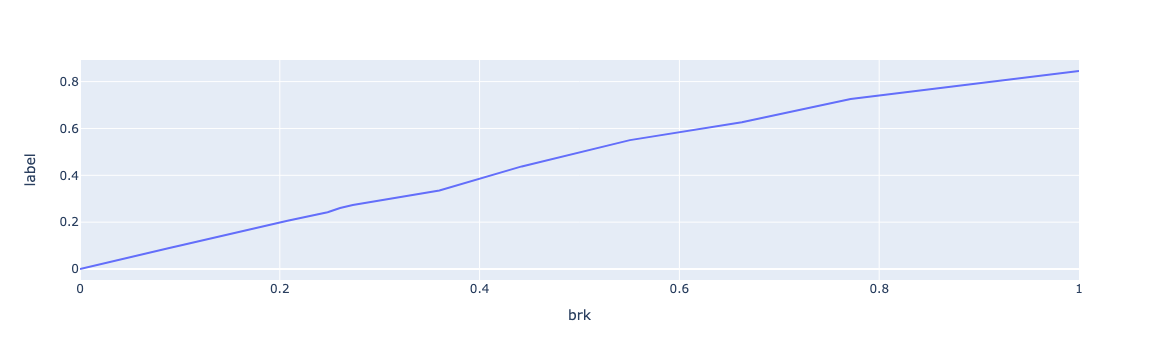

In [103]:
result = tmp.with_columns(
    (pl.col(f'{pred_col}_calibration').qcut(np.linspace(0, 1, qcut_num), allow_duplicates=True, include_breaks=True)
    ).alias(f"{event}_cut")
).unnest(f"{event}_cut").group_by(f"{pred_col}_calibration_bin").agg(pl.col('label').mean() , pl.col('brk').mean())

df = result.sort(['brk']).to_pandas()
fig = px.line(df, x="brk", y="label")
fig.show()

In [54]:
result

stacking_prediction_onset_bin,label,brk
cat,f64,f64
"""(0.00002187036…",0.007532,0.000025
"""(0.00012296548…",0.000336,0.00017
"""(0.00004122648…",0.003923,0.000047
"""(0.00000413906…",0.000852,0.000004
"""(0.00000504108…",0.001211,0.000005
"""(0.00000441736…",0.000919,0.000005
"""(0.00024677749…",0.000381,0.000382
"""(0.00959164694…",0.097606,0.911843
"""(0.00000194936…",0.000852,0.000004
